In [1]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
import os.path
import PIL

import re
from collections import defaultdict, namedtuple

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def get_classes(path):
    directories = glob(os.path.expanduser(path) + '/*')
    return [dir.split('/')[-1] for dir in directories]
n_classes =  len(get_classes('~/p5/data/interim/train'))
n_classes

50

In [4]:
 vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [5]:
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = vgg19
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(n_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
train_path = os.path.expanduser('~/p5/data/interim/train')
test_path = os.path.expanduser('~/p5/data/interim/test')
valid_path = os.path.expanduser('~/p5/data/interim/valid')

In [5]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=6)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)


Found 2766 images belonging to 50 classes.
Found 605 images belonging to 50 classes.
Found 543 images belonging to 50 classes.


In [9]:
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
hist = model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=500,
                    verbose=2, 
                    callbacks=[es, mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500
 - 18s - loss: 14.0545 - acc: 0.0417 - val_loss: 14.7861 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to best_model.h5
Epoch 2/500
 - 17s - loss: 15.1158 - acc: 0.0000e+00 - val_loss: 14.9504 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/500
 - 16s - loss: 13.3905 - acc: 0.0000e+00 - val_loss: 13.5966 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/500
 - 17s - loss: 14.3029 - acc: 0.0000e+00 - val_loss: 14.5604 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/500
 - 16s - loss: 13.8515 - acc: 0.0417 - val_loss: 14.0662 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 0.00000
Epoch 6/500
 - 17s - loss: 13.6558 - acc: 0.0000e+00 - val_loss: 14.0449 - val_acc: 0.0000e+00

Epoch 00006: val_acc did not improve from 0.00000
Epoc


Epoch 00052: val_acc improved from 0.60000 to 0.65000, saving model to best_model.h5
Epoch 53/500
 - 16s - loss: 6.6854 - acc: 0.4167 - val_loss: 8.4655 - val_acc: 0.3500

Epoch 00053: val_acc did not improve from 0.65000
Epoch 54/500
 - 16s - loss: 5.0611 - acc: 0.5000 - val_loss: 7.7352 - val_acc: 0.4000

Epoch 00054: val_acc did not improve from 0.65000
Epoch 55/500
 - 16s - loss: 4.9584 - acc: 0.5417 - val_loss: 4.5119 - val_acc: 0.6000

Epoch 00055: val_acc did not improve from 0.65000
Epoch 56/500
 - 16s - loss: 7.5859 - acc: 0.3750 - val_loss: 9.2275 - val_acc: 0.2500

Epoch 00056: val_acc did not improve from 0.65000
Epoch 57/500
 - 17s - loss: 5.4831 - acc: 0.4167 - val_loss: 4.8691 - val_acc: 0.6500

Epoch 00057: val_acc did not improve from 0.65000
Epoch 58/500
 - 17s - loss: 6.4131 - acc: 0.4583 - val_loss: 4.5449 - val_acc: 0.4000

Epoch 00058: val_acc did not improve from 0.65000
Epoch 59/500
 - 17s - loss: 7.0804 - acc: 0.4583 - val_loss: 8.1964 - val_acc: 0.2500

Epoch


Epoch 00111: val_acc did not improve from 0.75000
Epoch 112/500
 - 17s - loss: 5.0409 - acc: 0.5833 - val_loss: 3.6522 - val_acc: 0.7500

Epoch 00112: val_acc improved from 0.75000 to 0.75000, saving model to best_model.h5
Epoch 113/500
 - 17s - loss: 3.5706 - acc: 0.7500 - val_loss: 4.2116 - val_acc: 0.6000

Epoch 00113: val_acc did not improve from 0.75000
Epoch 114/500
 - 17s - loss: 7.1466 - acc: 0.4167 - val_loss: 4.9669 - val_acc: 0.5500

Epoch 00114: val_acc did not improve from 0.75000
Epoch 115/500
 - 17s - loss: 3.7404 - acc: 0.6250 - val_loss: 2.0013 - val_acc: 0.7500

Epoch 00115: val_acc improved from 0.75000 to 0.75000, saving model to best_model.h5
Epoch 116/500
 - 17s - loss: 2.4300 - acc: 0.7500 - val_loss: 3.7577 - val_acc: 0.7000

Epoch 00116: val_acc did not improve from 0.75000
Epoch 117/500
 - 17s - loss: 5.6490 - acc: 0.5833 - val_loss: 5.5758 - val_acc: 0.4500

Epoch 00117: val_acc did not improve from 0.75000
Epoch 118/500
 - 17s - loss: 3.5019 - acc: 0.6667 -

 - 17s - loss: 2.5220 - acc: 0.6667 - val_loss: 3.6208 - val_acc: 0.7000

Epoch 00170: val_acc did not improve from 0.85000
Epoch 171/500
 - 17s - loss: 2.9252 - acc: 0.7083 - val_loss: 1.9502 - val_acc: 0.8000

Epoch 00171: val_acc did not improve from 0.85000
Epoch 172/500
 - 17s - loss: 3.1702 - acc: 0.7500 - val_loss: 2.6195 - val_acc: 0.8000

Epoch 00172: val_acc did not improve from 0.85000
Epoch 173/500
 - 17s - loss: 2.7435 - acc: 0.7083 - val_loss: 2.3133 - val_acc: 0.7000

Epoch 00173: val_acc did not improve from 0.85000
Epoch 174/500
 - 17s - loss: 1.2242 - acc: 0.8333 - val_loss: 3.8259 - val_acc: 0.6500

Epoch 00174: val_acc did not improve from 0.85000
Epoch 175/500
 - 17s - loss: 4.0553 - acc: 0.5833 - val_loss: 4.8670 - val_acc: 0.6500

Epoch 00175: val_acc did not improve from 0.85000
Epoch 176/500
 - 16s - loss: 2.1707 - acc: 0.7500 - val_loss: 2.9961 - val_acc: 0.7500

Epoch 00176: val_acc did not improve from 0.85000
Epoch 177/500
 - 17s - loss: 4.3505 - acc: 0.666


Epoch 00229: val_acc did not improve from 0.90000
Epoch 230/500
 - 23s - loss: 1.8972 - acc: 0.8333 - val_loss: 4.0440 - val_acc: 0.7500

Epoch 00230: val_acc did not improve from 0.90000
Epoch 231/500
 - 19s - loss: 1.7774 - acc: 0.7917 - val_loss: 1.7690 - val_acc: 0.8500

Epoch 00231: val_acc did not improve from 0.90000
Epoch 232/500
 - 19s - loss: 0.1618 - acc: 0.9167 - val_loss: 2.7333 - val_acc: 0.7000

Epoch 00232: val_acc did not improve from 0.90000
Epoch 233/500
 - 20s - loss: 2.3579 - acc: 0.7917 - val_loss: 2.1034 - val_acc: 0.8500

Epoch 00233: val_acc did not improve from 0.90000
Epoch 234/500
 - 19s - loss: 3.1737 - acc: 0.6250 - val_loss: 4.2212 - val_acc: 0.7000

Epoch 00234: val_acc did not improve from 0.90000
Epoch 235/500
 - 18s - loss: 3.7979 - acc: 0.6250 - val_loss: 3.0382 - val_acc: 0.7500

Epoch 00235: val_acc did not improve from 0.90000
Epoch 236/500
 - 19s - loss: 0.1017 - acc: 0.9583 - val_loss: 2.6577 - val_acc: 0.7000

Epoch 00236: val_acc did not impr

 - 16s - loss: 1.4129 - acc: 0.8750 - val_loss: 2.6788 - val_acc: 0.7500

Epoch 00289: val_acc did not improve from 1.00000
Epoch 290/500
 - 16s - loss: 3.8640 - acc: 0.6667 - val_loss: 3.3220 - val_acc: 0.7500

Epoch 00290: val_acc did not improve from 1.00000
Epoch 291/500
 - 16s - loss: 2.2619 - acc: 0.7500 - val_loss: 3.2026 - val_acc: 0.6500

Epoch 00291: val_acc did not improve from 1.00000
Epoch 292/500
 - 16s - loss: 2.0283 - acc: 0.8750 - val_loss: 0.0702 - val_acc: 0.9500

Epoch 00292: val_acc did not improve from 1.00000
Epoch 293/500
 - 16s - loss: 1.7080 - acc: 0.8750 - val_loss: 1.6060 - val_acc: 0.8000

Epoch 00293: val_acc did not improve from 1.00000
Epoch 294/500
 - 16s - loss: 0.9332 - acc: 0.8750 - val_loss: 4.3988 - val_acc: 0.7000

Epoch 00294: val_acc did not improve from 1.00000
Epoch 295/500
 - 16s - loss: 1.4098 - acc: 0.8750 - val_loss: 3.4661 - val_acc: 0.7500

Epoch 00295: val_acc did not improve from 1.00000
Epoch 296/500
 - 16s - loss: 2.6899 - acc: 0.833

In [11]:
for key in hist.history:
    print(key)

val_loss
val_acc
loss
acc


In [ ]:
model = 

In [12]:
!ls

Hieroglyph_Classifier.ipynb        hieroglyphs_vgg19.h5
Hieroglyph_Classifier_backup.ipynb hieroglyphs_weights_095_095.sav
best_model.h5


In [13]:
# model.save('hieroglyphs_vgg19.h5')

In [6]:
model = load_model('hieroglyphs_vgg19.h5')












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [7]:
# predictions = model.predict_generator(test_batches, steps=1, verbose=1)

In [19]:
STEP_SIZE_TEST=test_batches.n//test_batches.batch_size
test_batches.reset()
pred=model.predict_generator(test_batches,
steps=STEP_SIZE_TEST,
verbose=1)

543/543 [==============================] - 219s 403ms/step


In [32]:
predicted_class_indices=np.argmax(pred,axis=1)

In [49]:
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
pred_dict = {'predictions': predictions,
             'class_index': predicted_class_indices,
             'filename': test_batches.filenames}
df = pd.DataFrame(pred_dict)
df['glyph'] = df.apply(lambda row: re.match(r'^([A-Z]{1}\d+)/', row['filename']).group(1), axis=1)
df['match'] = df['predictions'] == df['glyph']
df['file_class_index'] = df.apply(lambda row: train_batches.class_indices[row['glyph']], axis=1)
df.head()

,predictions,class_index,filename,glyph,match,file_class_index
0,D2,0,D2/070242_D2.png,D2,True,0
1,D2,0,D2/220196_D2.png,D2,True,0
2,D21,1,D21/030269_D21.png,D21,True,1
3,D21,1,D21/030273_D21.png,D21,True,1
4,D21,1,D21/050286_D21.png,D21,True,1


In [51]:
df[df['match'] == False].sample(10)

,predictions,class_index,filename,glyph,match,file_class_index
240,S29,38,M17/230056_M17.png,M17,False,19
349,O50,33,O49/070133_O49.png,O49,False,32
276,D35,3,N31/230453_N31.png,N31,False,26
338,O50,33,N5/030115_N5.png,N5,False,29
275,V31,44,N31/220226_N31.png,N31,False,26
15,E34,9,D21/220012_D21.png,D21,False,1
331,E34,9,N35/410299_N35.png,N35,False,27
171,X1,48,G5/220087_G5.png,G5,False,16
49,D21,1,D46/030340_D46.png,D46,False,6
57,X1,48,D54/410279_D54.png,D54,False,7


In [52]:
acc = df['match'].sum() / len(pred_df)
acc

0.9208103130755064

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import seaborn as sns

In [73]:
print("Glyph confusion matrix: \n\n", confusion_matrix(df['file_class_index'], df['class_index']))

print('\nF1 Score:' , f1_score(df['file_class_index'], df['class_index'], average='weighted'))
print('\nRecall Score:' , recall_score(df['file_class_index'], df['class_index'], average='weighted'))
print('\nClassification Report:\n' , classification_report(df['file_class_index'], df['class_index']))

Glyph confusion matrix: 

 [[ 2  0  0 ...  0  0  0]
 [ 0 21  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  0 41  0]
 [ 0  0  0 ...  0  0  7]]

F1 Score: 0.9057478153725173

Recall Score: 0.9208103130755064

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.95      0.95      0.95        22
           2       0.75      1.00      0.86         3
           3       0.67      1.00      0.80         8
           4       1.00      0.88      0.93         8
           5       1.00      0.83      0.91         6
           6       0.83      0.71      0.77         7
           7       0.00      0.00      0.00         2
           8       1.00      1.00      1.00         6
           9       0.88      0.78      0.82        18
          10       0.71      0.83      0.77         6
          11       0.94      0.97      0.95        32
          12       1.00  

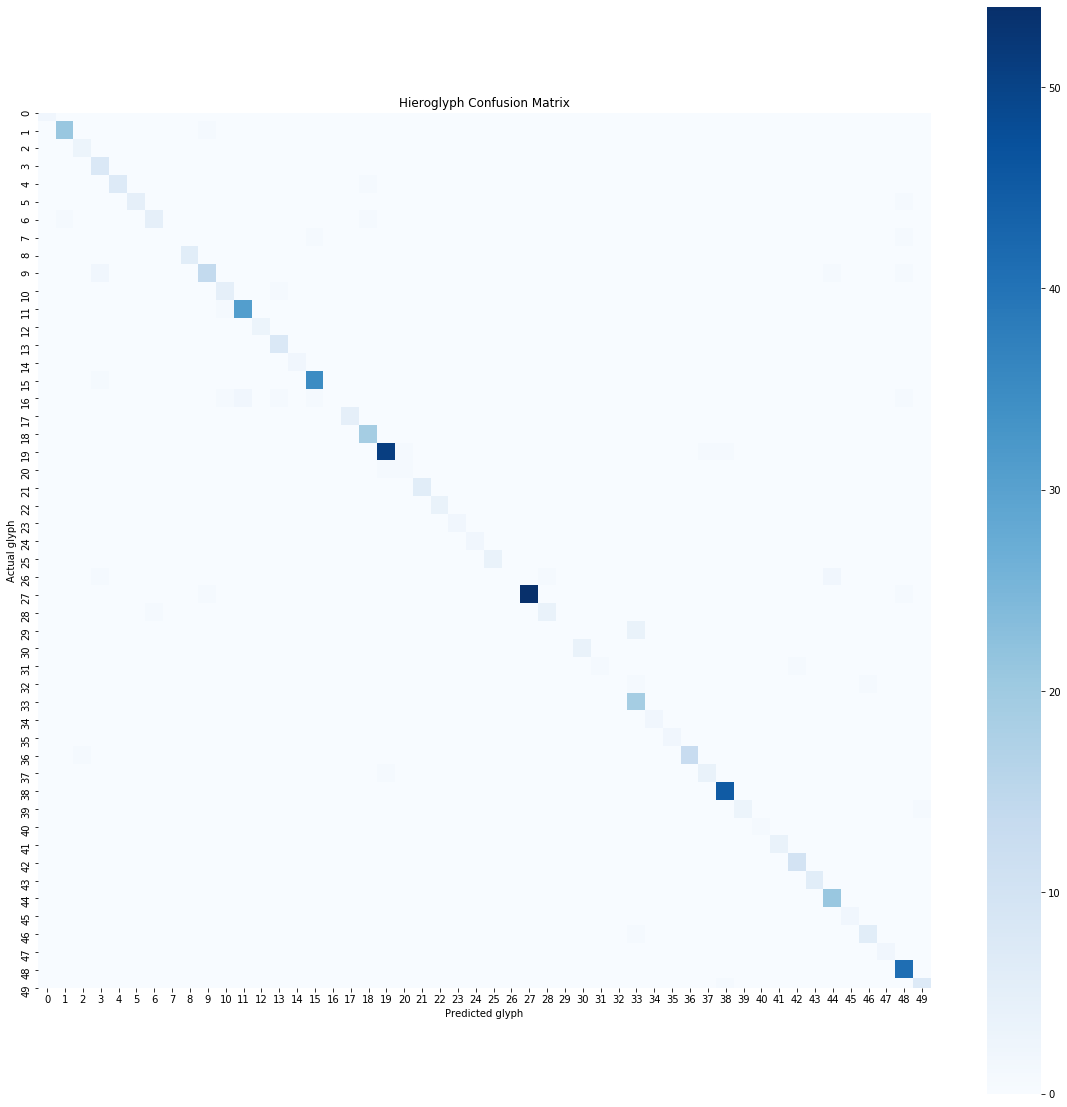

In [63]:
# Print confusion matrix for kNN
glyph_confusion = confusion_matrix(df['file_class_index'], df['class_index'])
plt.figure(figsize=(20,20))
sns.heatmap(glyph_confusion, cmap=plt.cm.Blues, annot=False, square=True)#,
#            xticklabels=df['predictions'],
#            yticklabels=df['glyph'])

plt.xlabel('Predicted glyph')
plt.ylabel('Actual glyph')
plt.title('Hieroglyph Confusion Matrix');

In [14]:
# model = load_model(os.path.expanduser('~/p5/models/hieroglyphs_vgg19.h5'))

In [74]:
test_batches = ImageDataGenerator().flow_from_directory(os.path.expanduser('~/p5/data/single'), 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)

Found 7 images belonging to 1 classes.


In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, lm.predict_proba(X_test)[:,1])

### PLAY

In [92]:
temp = np.random.randn(50,100)
# temp

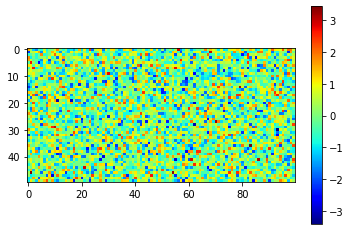

In [93]:
plt.imshow(temp,cmap = 'jet')
plt.colorbar()

In [96]:
import cv2 


In [97]:
!ls

Hieroglyph_Classifier.ipynb        best_model.h5
Hieroglyph_Classifier_backup.ipynb hieroglyphs_vgg19.h5
Opencv_test.ipynb                  hieroglyphs_weights_095_095.sav
SarcEastGH.jpg


In [98]:
img = cv2.imread('SarcEastGH.jpg')  


In [99]:
img.shape

(1060, 1720, 3)

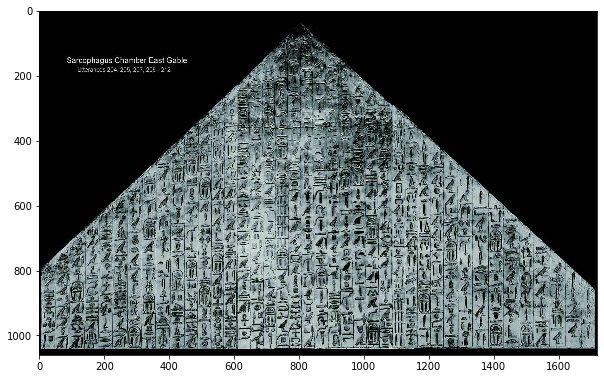

In [101]:
plt.figure(figsize=[10,10])
plt.imshow(img)

In [102]:
temp = np.random.randn(1060,1720,3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


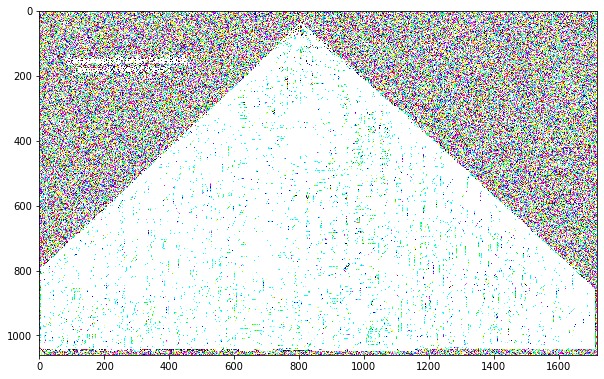

In [103]:
plt.figure(figsize=[10,10])
plt.imshow(img+temp)